step0. 라이브러리 임포트

In [1]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
import glob
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


step1. 엑셀 데이터 시트 받기

In [2]:
# 1) google drive에 연결 + 저장되어 있는 excel 파일 불러오기
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/Colab notebook/sEMG_data/sEMG_data_*.csv'
file_list = sorted(glob.glob(DATA_PATH))


# 윈도우 자르는 함수 (이전과 동일)
def create_windows(data, window_size, step_size):
    X = []
    y = []
    channels = data[['Ch1', 'Ch2', 'Ch3', 'Ch4']].values
    labels = data['label'].values

    for i in range(0, len(data) - window_size, step_size):
        window_data = channels[i : i + window_size]
        # 윈도우의 마지막 시점 라벨을 정답으로 사용
        window_label = labels[i + window_size - 1]

        X.append(window_data.T) # (채널, 시간) 형태로 변환
        y.append(window_label)

    return X, y

# ========================================================
# ★ 핵심 수정 부분: 파일별로 독립적으로 처리하기 ★
# ========================================================

all_X_list = []
all_y_list = []

WINDOW_SIZE = 200
STEP_SIZE = 100

print(f"총 {len(file_list)}개의 파일을 독립적으로 처리합니다...")

for file in file_list:
    try:
        # 1. 개별 파일 읽기
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip() # 공백 제거

        # 2. 개별 파일 내에서만 윈도우 자르기 (섞임 방지!)
        X_chunk, y_chunk = create_windows(df, WINDOW_SIZE, STEP_SIZE)

        # 3. 잘라낸 조각들을 리스트에 추가
        all_X_list.extend(X_chunk)
        all_y_list.extend(y_chunk)

        print(f"  -> {os.path.basename(file)} 처리 완료 (생성된 샘플: {len(X_chunk)}개)")

    except Exception as e:
        print(f"❌ 에러 발생 ({os.path.basename(file)}): {e}")

# 4. 최종적으로 모든 조각을 하나의 numpy 배열로 변환
X_final = np.array(all_X_list)
y_final = np.array(all_y_list)

print("\n✅ 최종 데이터셋 생성 완료!")
print(f"Input Shape: {X_final.shape}") # (총 샘플 수, 4, 200)
print(f"Target Shape: {y_final.shape}")

# 이후 학습 코드(train_test_split 등)는 이전과 동일하게 진행하면 됩니다.




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. 엑셀 파일 업로드 및 pandas로 변환

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 선택 버튼 누르고 파일 선택하기

file_name = list(uploaded.keys())[0]  # 업로드된 파일 이름 가져오기
print(f"\n업로드된 파일: {file_name}")

df = pd.read_excel(file_name) # pandas 로 엑셀 파일 가져오기


#검증
print("\n--- 데이터 미리보기 ---")
print(df.head(10))
print(f"\n데이터 형태: {df.shape}")
print(f"컬럼 이름: {df.columns.tolist()}")



Saving semg_test_dat_random.xlsx to semg_test_dat_random (1).xlsx

업로드된 파일: semg_test_dat_random (1).xlsx

--- 데이터 미리보기 ---
   time(s)    semg_1    semg_2    semg_3    semg_4  label
0    0.000  0.006126  0.183556 -0.020726  0.108688      0
1    0.005  0.022530  0.016944  0.035504  0.117609      0
2    0.010  0.235027  0.221430  0.143781  0.244632      0
3    0.015  0.082916  0.216565  0.358230  0.494384      0
4    0.020  0.204330  0.252005  0.314150  0.383238      0
5    0.025  0.184475  0.311515  0.492214  0.583005      0
6    0.030  0.387486  0.376179  0.372809  0.707331      0
7    0.035  0.209718  0.475467  0.419347  0.477958      0
8    0.040  0.296489  0.363647  0.448216  0.636982      0
9    0.045  0.314783  0.529876  0.426212  0.828103      0

데이터 형태: (2400, 6)
컬럼 이름: ['time(s)', 'semg_1', 'semg_2', 'semg_3', 'semg_4', 'label']


### 3. 데이터 추출

In [ ]:
sensor_columns = ['semg_1', 'semg_2', 'semg_3', 'semg_4']  # 실제 컬럼명에 맞게 수정하기
raw_sensor_data = df[sensor_columns].values  # Numpy로 변환하기 // shape =  (전체_시간포인트, 채널수)의 2차원 행렬 [[semg1,semg2,semg3,semg4], [semg1,semg2,semg3,semg4], ...]
labels = df['label'].values  # 실제 컬럼명에 맞게 수정하기 // shape = (전체 시간 개수, 1) or (전체 시간 개수,)

#검증
print(f"\n센서 데이터 형태: {raw_sensor_data.shape}")
print(f"라벨 형태: {labels.shape}")
print(f"고유한 라벨 값: {np.unique(labels)}")  # label 종류 출력 ex) 1,2,3,4


센서 데이터 형태: (2400, 4)
라벨 형태: (2400,)
고유한 라벨 값: [0 1 2 3]


4. Butterworth Band-pass Filter

In [ ]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # 나이퀴스트 주파수 (샘플링 레이트의 절반) (만약 200HZ로 우리가 semg 센서 사용시 nyq = 100HZ)
    low = lowcut / nyq
    high = highcut / nyq

    # 안전장치: 만약 high가 1보다 크거나 같으면 0.99로 강제 조정
    if high >= 1.0:
        print(f"경고: Highcut 주파수({highcut}Hz)가 Nyquist 주파수({nyq}Hz)보다 높거나 같습니다.")
        print("Highcut을 자동으로 조정합니다.")
        high = 0.99

    # b, a: 필터 계수 계산
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_semg_filter(data, lowcut, highcut, fs, order=4):
    """
    sEMG 데이터에 Butterworth Band-pass Filter 적용
    - data: (샘플 수, 채널 수) 형태의 numpy 배열 또는 DataFrame
    - lowcut: 통과시킬 최저 주파수 (보통 20Hz)
    - highcut: 통과시킬 최고 주파수 (보통 400~450Hz)
    - fs: 센서의 샘플링 레이트 (Hz) - 우리의 경우 200HZ로 해놓았다
    - order: 필터 차수 (보통 4)
    """

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)

    y = filtfilt(b, a, data, axis=0) # filtfilt: 위상 왜곡(Phase Shift) 없이 필터링 (데이터를 앞뒤로 두 번 통과시킴) # axis=0은 행(시간) 방향으로 필터를 적용한다는 의미
    return y



In [ ]:
raw_sensor_data = df[sensor_columns].values

# ★ 200Hz 맞춤 설정 ★
FS = 200.0       # sampling rate(HZ)
LOW_CUT = 20.0   # 20Hz 미만 잡음(움직임 등) 제거
HIGH_CUT = 90.0  # FS의 절반 이하여야 함 // 여기서는 안전하게 90Hz로 설정

print(f"필터 적용 중... (FS={FS}Hz, Band=[{LOW_CUT}~{HIGH_CUT}Hz])")

# 필터링 수행
sensor_data = apply_semg_filter(
    raw_sensor_data,
    lowcut=LOW_CUT,
    highcut=HIGH_CUT,
    fs=FS,
    order=4 #채널이 4개일때
)

print("필터링 완료!")
print("필터링 전 데이터(상위 1행):", raw_sensor_data[0])
print("필터링 후 데이터(상위 1행):", sensor_data[0])



필터 적용 중... (FS=200.0Hz, Band=[20.0~90.0Hz])
필터링 완료!
필터링 전 데이터(상위 1행): [ 0.006126  0.183556 -0.020726  0.108688]
필터링 후 데이터(상위 1행): [-0.00010397 -0.00013663 -0.00019344  0.00037438]


### 5. Normalization 및 preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler


# StandardScaler 객체 생성
scaler = StandardScaler()

# 정규화 수행
# sensor_data는 위에서 필터링이 완료된 (전체 샘플 수, 4) 형태의 Numpy 배열입니다.
# fit_transform은 평균과 표준편차를 계산(fit)하고, 데이터를 변환(transform)합니다.
sensor_data_normalized = scaler.fit_transform(sensor_data)




# 확인을 위한 출력
print(f"데이터 형태: {sensor_data.shape}")
print(f"평균(약 0이어야 함): {sensor_data.mean(axis=0)}")
print(f"표준편차(약 1이어야 함): {sensor_data.std(axis=0)}")
print("\n정규화된 데이터 예시 (첫 3행):")
print(sensor_data[:3])




--- 데이터 정규화 시작 (StandardScaler) ---
정규화 완료!
데이터 형태: (2400, 4)
평균(약 0이어야 함): [-3.36731511e-17 -1.44025417e-17 -1.05427819e-17 -3.08180854e-17]
표준편차(약 1이어야 함): [1. 1. 1. 1.]

정규화된 데이터 예시 (첫 3행):
[[-6.30349584e-04  5.85749805e-04  1.23550811e-04  6.57750032e-03]
 [-3.19078241e-01 -2.02736143e+00 -6.60539923e-01 -8.67622293e-01]
 [ 1.24767117e+00  3.93910958e-01 -3.43961077e-01 -4.25570452e-01]]


6. 1D CNN Windowing 설정

In [ ]:
# 5. 윈도잉(Windowing): 시계열 데이터를 고정 길이의 세그먼트로 자르기
def create_windows(data, labels, window_size, step_size):
    """
    시계열 데이터를 슬라이딩 윈도우 방식으로 잘라 샘플 생성

    Parameters:
    - data: (전체_시간포인트, 채널수) 형태의 센서 데이터
    - labels: (전체_시간포인트,) 형태의 라벨
    - window_size: 한 샘플에 포함될 시간 포인트 수 (예: 128)
    - step_size: 윈도우를 이동할 간격 (예: 64면 50% 겹침)

    Returns:
    - X: (샘플수, window_size, 채널수)
    - y: (샘플수,)
    """
    X = []
    y = []

    for i in range(0, len(data) - window_size + 1, step_size):  # w

        window = data[i:i + window_size]                         # 해당 윈도우의 라벨 (윈도우 중간 지점의 라벨 사용)
        label = labels[i + window_size // 2]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


# 윈도우 파라미터 설정
WINDOW_SIZE = 128  # 한 샘플당 128개의 시간 포인트
STEP_SIZE = 64     # 50% 겹침 (overlap)

# 윈도우 생성
X, y = create_windows(sensor_data_normalized, labels, WINDOW_SIZE, STEP_SIZE)

print(f"\n--- 윈도잉 후 데이터 형태 ---")
print(f"X (입력 데이터): {X.shape}  # (샘플수, 타임스텝, 채널수)")
print(f"y (라벨): {y.shape}  # (샘플수,)")



--- 윈도잉 후 데이터 형태 ---
X (입력 데이터): (36, 128, 4)  # (샘플수, 타임스텝, 채널수)
y (라벨): (36,)  # (샘플수,)


### 6. label one-hot encoding

In [ ]:
# 6. 라벨 원-핫 인코딩
N_CLASSES = len(np.unique(y))
y_onehot = tf.keras.utils.to_categorical(y, num_classes=N_CLASSES)

print(f"\n클래스 개수: {N_CLASSES}")
print(f"원-핫 인코딩된 라벨 형태: {y_onehot.shape}")


클래스 개수: 4
원-핫 인코딩된 라벨 형태: (36, 4)


### 7. train/validation/test set으로 분할

In [ ]:
# 7. 훈련/테스트 데이터 분할
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val.argmax(axis=1))

print(f"\n--- 데이터 분할 결과 ---")
print(f"훈련 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")


--- 데이터 분할 결과 ---
훈련 데이터: (21, 128, 4)
테스트 데이터: (8, 128, 4)


### 8. 1D-CNN

In [ ]:
# 8. 1D-CNN 모델 구축
N_TIMESTEPS = X.shape[1]  # 128
N_CHANNELS = X.shape[2]   # 4

model = Sequential([
    # 첫 번째 Conv Block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(N_TIMESTEPS, N_CHANNELS)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    # 두 번째 Conv Block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    # Fully Connected Layers
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])

print("\n--- 모델 구조 ---")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- 모델 구조 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 58, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       371,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,872 (1.75 MB)

 Trainable params: 458,872 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

### 9. 모델 학습

In [ ]:
# 9. 모델 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# 11. 모델 학습
print("\n--- 모델 학습 시작 ---")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)



--- 모델 학습 시작 ---
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1905 - loss: 1.5240 - val_accuracy: 0.1429 - val_loss: 1.4490
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1429 - loss: 1.5663 - val_accuracy: 0.1429 - val_loss: 1.4470
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4286 - loss: 1.4373 - val_accuracy: 0.2857 - val_loss: 1.4052
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2857 - loss: 1.4613 - val_accuracy: 0.5714 - val_loss: 1.3709
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3333 - loss: 1.4104 - val_accuracy: 0.4286 - val_loss: 1.3640
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3333 - loss: 1.4349 - val_accuracy: 0.5714 - val_loss: 1.3713
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1905 - loss: 1.5151 - val_accuracy: 0.4286 - val_loss: 1.3769
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4286 - loss: 1.4139 - val_accuracy: 0.

### 10. 모델 평가

In [ ]:
print("\n--- 최종 모델 평가 (테스트 세트) ---")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 데이터 정확도: {accuracy * 100:.2f}%")


--- 최종 모델 평가 (테스트 세트) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - accuracy: 0.5000 - loss: 0.9422
테스트 데이터 정확도: 50.00%


### 11. 학습 과정 시각화

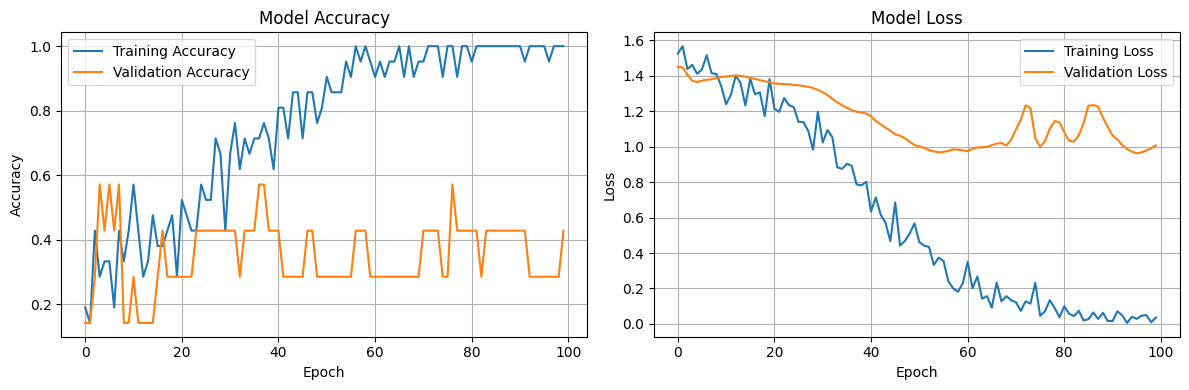

In [ ]:
# 13. 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

12. 예측 테스트

In [ ]:
# 14. 예측 테스트
sample_idx = 0
sample = np.expand_dims(X_test[sample_idx], axis=0)
prediction = model.predict(sample)
predicted_class = np.argmax(prediction)
actual_class = np.argmax(y_test[sample_idx])

print(f"\n--- 예측 예시 ---")
print(f"예측 확률: {prediction[0]}")
print(f"예측된 클래스: {predicted_class}")
print(f"실제 클래스: {actual_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step

--- 예측 예시 ---
예측 확률: [0.16657239 0.62334853 0.20020308 0.00987604]
예측된 클래스: 1
실제 클래스: 2


13.모델 저장(이건 안해도 됨)

In [ ]:
# 15. 모델 저장 (선택사항)
# model.save('semg_1dcnn_model.h5')
# print("\n모델이 'semg_1dcnn_model.h5'로 저장되었습니다.")